# Bike Sharing Linear Regression Model

## Steps
1. Reading , understanding and Visualizing the data
2. Preparing the data for Modelling
    - Train - Test split
    - Rescaling
3. Training the Model 
4. Residual Analysis
5. Predictions and Evaluations on the test set

### Step 1: Reading , understanding and Visualizing the data

In [1]:
# Import Needed Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import calendar


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# Setting Plot size globally for better visualization
plt.rcParams["figure.figsize"] = (15,10)

In [3]:
# Read the dataset
bike_sharing = pd.read_csv('day.csv')
bike_sharing.shape

(730, 16)

In [4]:
bike_sharing.info()

"""No Missing Values and no datatype conversions required"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


'No Missing Values and no datatype conversions required'

In [5]:
# Drop Insignificant Columns
# instant is unique as it is a record index - it doesn't add any value
# casual and registered are already captured in cnt and the target column is cnt, hence dropping casual and registered
# dropping dteday as the date doesn't add significance because it is already being consumed in other significant forms like month,weekday,holiday and so on
insig_cols = ['instant','dteday','casual','registered']
bike_sharing.drop(insig_cols,axis=1,inplace=True)
bike_sharing.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

<Figure size 1080x720 with 0 Axes>

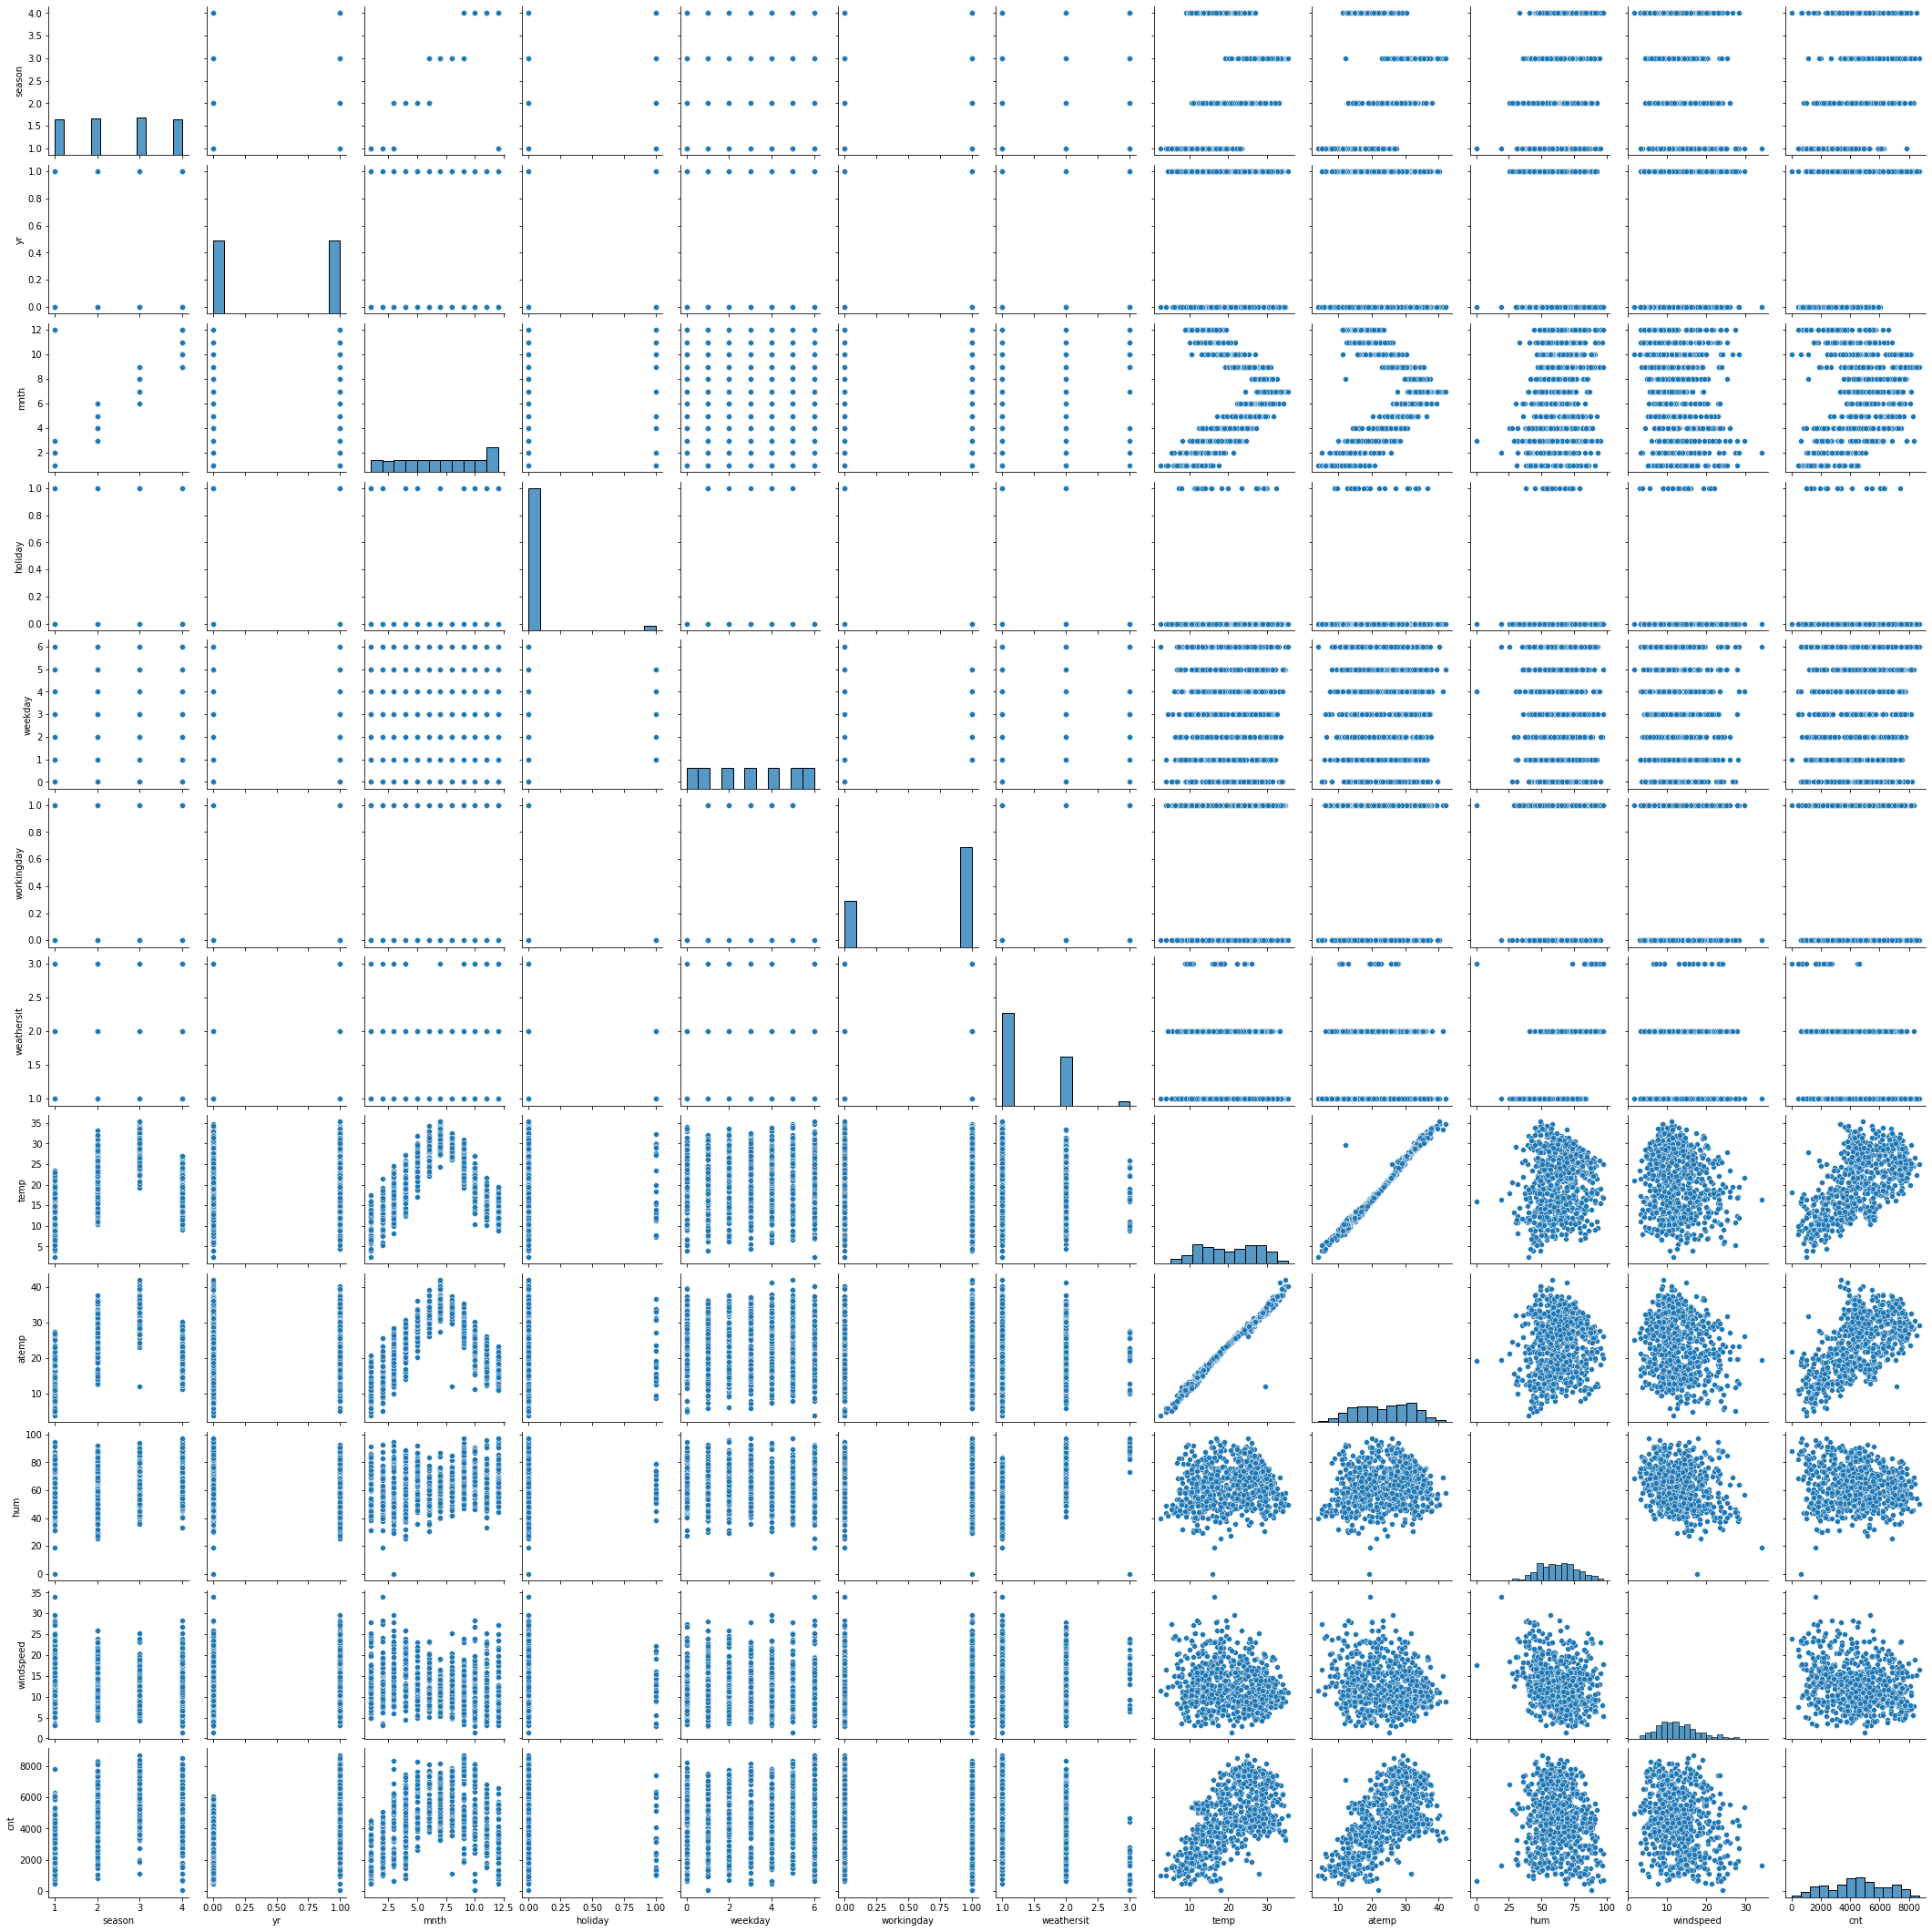

'At this point,temp and atemp may be multi collinear (+vely correlated) and is obviously explainable because temp is the actual temperature and atemp is feeling temperatue. '

In [6]:
# Visualizing the data for linearity and multi collinearity
plt.figure()
sns.pairplot(bike_sharing)
plt.show()

"""At this point,temp and atemp may be multi collinear (+vely correlated) and is obviously explainable because temp is the actual temperature and atemp is feeling temperatue. """

<Figure size 864x360 with 0 Axes>

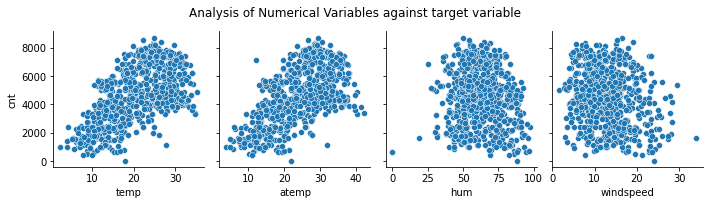

'There seems to be linear correlation between temp vs cnt and atemp vs cnt'

In [7]:
# Visualizing the data: Continuous Independent Variables
plt.figure(figsize=(12,5))
sns.pairplot(data=bike_sharing,x_vars=['temp', 'atemp', 'hum', 'windspeed'],y_vars='cnt')
plt.suptitle('Analysis of Numerical Variables against target variable',y=1.1)
plt.show()

"""There seems to be linear correlation between temp vs cnt and atemp vs cnt"""

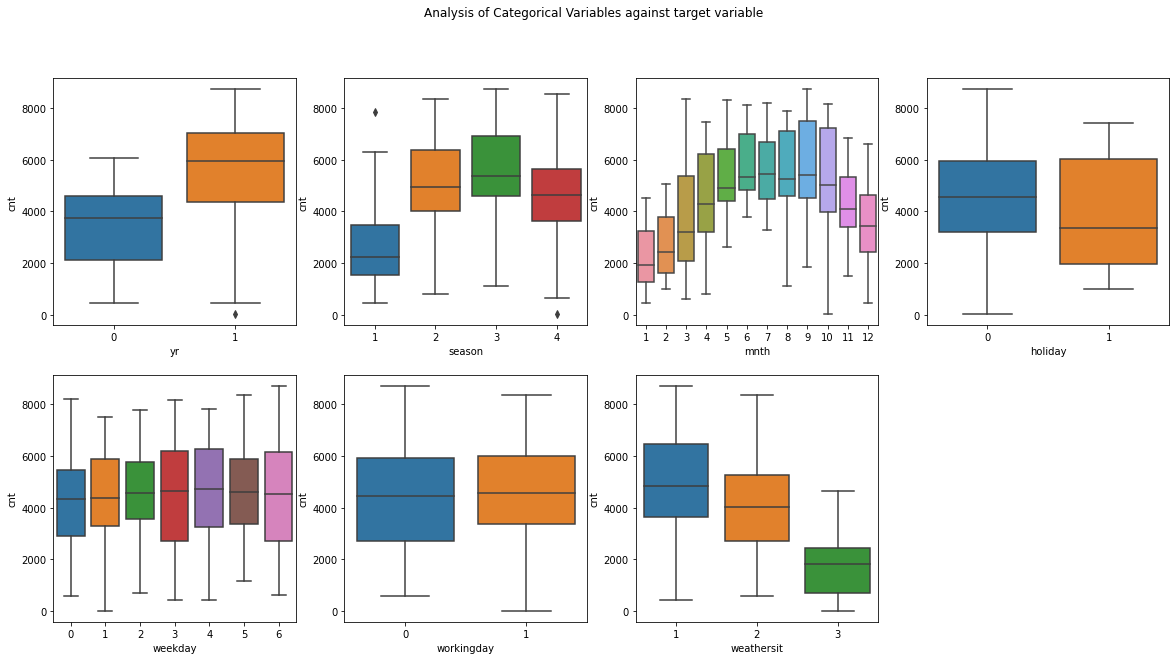

In [8]:
# Visualizing the data: Categorical Independent Variables
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
sns.boxplot(x='yr',y='cnt',data=bike_sharing)
plt.subplot(2,4,2)
sns.boxplot(x='season',y='cnt',data=bike_sharing)
plt.subplot(2,4,3)
sns.boxplot(x='mnth',y='cnt',data=bike_sharing)
plt.subplot(2,4,4)
sns.boxplot(x='holiday',y='cnt',data=bike_sharing)
plt.subplot(2,4,5)
sns.boxplot(x='weekday',y='cnt',data=bike_sharing)
plt.subplot(2,4,6)
sns.boxplot(x='workingday',y='cnt',data=bike_sharing)
plt.subplot(2,4,7)
sns.boxplot(x='weathersit',y='cnt',data=bike_sharing)
plt.suptitle('Analysis of Categorical Variables against target variable')
plt.show()


#### Inferences
- year seems to have very good influence of total rental bikes as the entire distribution for 2019 is higher than that of 2018 indicating a pattern
- season seems to have influence on number of people opting for total rental bikes thereby months also have influence. People tend to opt for more rental bikes in Summer and Fall 
- workingday & weekday doesn't seem to influence total rental bikes as the median and distribution is similar. 
- Weather situation seems to influence on total rental bikes where people opt for more rental bikes in clear or partly cloudy weather  
- People tend to opt for little more rental bikes during no holidays than on holidays. The influence could be little less appreciable attributing to the less difference in median

### Step 2:  Preparing the data for Modelling

#### Encoding
 - yes/no variables are already encoded with 1/0. No change needed
 - Certain Nominal Variables are represented as Ordinal variables like season, month, weekday, weathersit. Those has to be converted and dummy encoded

In [9]:
## Listing Categorical columns and its unique values
column_values = {}
col_list = ['yr','season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
for row in col_list:
    column_values[row] = list(bike_sharing[row].value_counts().index)

print(column_values)

{'yr': [1, 0], 'season': [3, 2, 1, 4], 'mnth': [12, 10, 8, 7, 5, 3, 1, 11, 9, 6, 4, 2], 'holiday': [0, 1], 'weekday': [6, 1, 0, 5, 4, 2, 3], 'workingday': [1, 0], 'weathersit': [1, 2, 3]}


In [10]:
## Plug in string values from data dict for Nominal Variables which are represented as Ordinal values in the dataset
yr_mappings = {0:'2018',1:'2019'}
season_mappings = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
weathersit_mappings = {1:'Clear',2:'Mist_Cloudy',3:'Light_Snow',4:'Heavy_Rain'}

bike_sharing['yr'] = bike_sharing[['yr']].apply(lambda x : x.map(yr_mappings))
bike_sharing['season'] = bike_sharing[['season']].apply(lambda x : x.map(season_mappings))
bike_sharing['weathersit'] = bike_sharing[['weathersit']].apply(lambda x : x.map(weathersit_mappings))
bike_sharing['mnth'] = bike_sharing['mnth'].apply(lambda x : calendar.month_abbr[x])
bike_sharing['weekday'] = bike_sharing['weekday'].apply(lambda x : calendar.day_abbr[x])
bike_sharing.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Sun,0,Mist_Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Mon,0,Mist_Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Tue,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Wed,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Thu,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [11]:
## Dummy encoding
var_list_encoding = ['yr','season','mnth','weekday','weathersit']
dummy_encoded_values = pd.get_dummies(data=bike_sharing[var_list_encoding],drop_first=True)

# Add the new encoded cols to original dataframe and drop the source columns
bike_sharing = pd.concat([bike_sharing,dummy_encoded_values],axis=1)
bike_sharing.drop(var_list_encoding,axis=1,inplace=True)

#### Split test train dataset

In [12]:
df_train, df_test = train_test_split(bike_sharing,train_size=0.7,random_state=100)
df_train.columns

Index(['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'yr_2019', 'season_spring', 'season_summer', 'season_winter',
       'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun',
       'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed', 'weathersit_Light_Snow',
       'weathersit_Mist_Cloudy'],
      dtype='object')

#### Scaling the features using MinMaxScaler

In [13]:
# Normalize the numerical columns other than categorical dummy cols
num_vars = ['temp','atemp','hum','windspeed','cnt']
scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])


### Step 3:  Model Building

#### Dividing training set to X and y

In [14]:
y_train = df_train.pop('cnt')
X_train = df_train

In [15]:
# Create Linear Regression Model
lm = LinearRegression()
lm.fit(X_train,y_train)

# Running RFE with output number of values as 20
output_var_count = 20
rfe = RFE(lm,n_features_to_select=output_var_count)
rfe = rfe.fit(X_train, y_train)


In [16]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('yr_2019', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 3),
 ('mnth_Dec', True, 1),
 ('mnth_Feb', True, 1),
 ('mnth_Jan', True, 1),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 8),
 ('mnth_Mar', False, 10),
 ('mnth_May', False, 2),
 ('mnth_Nov', True, 1),
 ('mnth_Oct', False, 7),
 ('mnth_Sep', True, 1),
 ('weekday_Mon', True, 1),
 ('weekday_Sat', False, 6),
 ('weekday_Sun', True, 1),
 ('weekday_Thu', False, 9),
 ('weekday_Tue', False, 5),
 ('weekday_Wed', False, 4),
 ('weathersit_Light_Snow', True, 1),
 ('weathersit_Mist_Cloudy', True, 1)]

In [17]:
resulting_rfe_cols = X_train.columns[rfe.support_]
resulting_rfe_cols

Index(['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'yr_2019',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Dec',
       'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Nov', 'mnth_Sep',
       'weekday_Mon', 'weekday_Sun', 'weathersit_Light_Snow',
       'weathersit_Mist_Cloudy'],
      dtype='object')

In [18]:
X_train.columns[~rfe.support_]

Index(['mnth_Aug', 'mnth_Jun', 'mnth_Mar', 'mnth_May', 'mnth_Oct',
       'weekday_Sat', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed'],
      dtype='object')

#### Building using stats model to get detailed statistics

In [19]:
# Keeping only the columns from RFE
X_train_rfe = X_train[resulting_rfe_cols]

In [20]:
# Add Constant
def add_constant(X_train):
    return sm.add_constant(X_train)

In [21]:
## Build Model and return summary
def build_model(X_train,y_train):
    lm = sm.OLS(y_train,X_train).fit() # Fitting the model
    return lm.summary(),lm # Return summary

In [22]:
# Compute VIF
def compute_vif(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2) # Rounding to 2 decimal values
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif
    

In [23]:
# Building Model with 20 params from RFE
build_model(add_constant(X_train_rfe),y_train)


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.851
 Model:                            OLS   Adj. R-squared:                  0.845
 Method:                 Least Squares   F-statistic:                     147.4
 Date:                Wed, 09 Feb 2022   Prob (F-statistic):          1.23e-188
 Time:                        19:29:08   Log-Likelihood:                 524.49
 No. Observations:                 510   AIC:                            -1009.
 Df Residuals:                     490   BIC:                            -924.3
 Df Model:                          19                                         
 Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------

In [24]:
# Computing VIF for 15 variables from RFE
compute_vif(X_train_rfe)

,Features,VIF
2,temp,59.17
1,workingday,58.45
3,atemp,53.88
17,weekday_Sun,13.95
16,weekday_Mon,13.36
7,season_spring,5.79
9,season_winter,3.98
0,holiday,3.33
8,season_summer,2.94
12,mnth_Jan,2.37


##### Interpretations:
- RFE chosen 20 variables is able to explain 84% variance in the target variable (Adjusted R square is 84%)
- atemp has high p value and high VIF, Let's start by removing atemp

In [25]:
# Remove atemp which has very high p value and high VIF
cols_to_be_removed = ['atemp']
X_train_rfe_m = X_train_rfe.drop(cols_to_be_removed,axis=1)

In [26]:
build_model(add_constant(X_train_rfe_m),y_train)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.851
 Model:                            OLS   Adj. R-squared:                  0.846
 Method:                 Least Squares   F-statistic:                     155.9
 Date:                Wed, 09 Feb 2022   Prob (F-statistic):          9.80e-190
 Time:                        19:29:12   Log-Likelihood:                 524.48
 No. Observations:                 510   AIC:                            -1011.
 Df Residuals:                     491   BIC:                            -930.5
 Df Model:                          18                                         
 Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------

In [27]:
compute_vif(X_train_rfe_m)

,Features,VIF
1,workingday,58.40
16,weekday_Sun,13.94
15,weekday_Mon,13.35
6,season_spring,5.69
2,temp,4.73
8,season_winter,3.85
0,holiday,3.32
7,season_summer,2.82
11,mnth_Jan,2.37
3,hum,1.94


##### Interpretations:
- Adjusted R square has remained the same indicating that atemp is a redundant variable
- As indicated by EDA, atemp has very high correlation with temp, removing atemp also brought down vif of temp
- holiday has high p value although it has low VIF

As a rule of thumb, remove the variable with high p value, let's remove holiday

In [28]:
# Remove atemp which has very high p value and high VIF
# Remove holiday as it has high p value
cols_to_be_removed = ['atemp','holiday']
X_train_rfe_m = X_train_rfe.drop(cols_to_be_removed,axis=1)

In [29]:
build_model(add_constant(X_train_rfe_m),y_train)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.851
 Model:                            OLS   Adj. R-squared:                  0.846
 Method:                 Least Squares   F-statistic:                     155.9
 Date:                Wed, 09 Feb 2022   Prob (F-statistic):          9.80e-190
 Time:                        19:29:13   Log-Likelihood:                 524.48
 No. Observations:                 510   AIC:                            -1011.
 Df Residuals:                     491   BIC:                            -930.5
 Df Model:                          18                                         
 Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------

In [30]:
compute_vif(X_train_rfe_m)

,Features,VIF
2,hum,34.64
1,temp,22.30
0,workingday,18.92
5,season_spring,6.05
15,weekday_Sun,5.04
3,windspeed,4.99
14,weekday_Mon,4.85
7,season_winter,4.40
6,season_summer,3.11
10,mnth_Jan,2.42


##### Interpretations:
- Adjusted R square has remained the same indicating that removed variables may not be good value add to the fitness of the model
- mnth_Feb has high p value > 0.05

let's remove mnth_Feb

In [31]:
# Remove atemp which has very high p value and high VIF
# Remove holiday as it has high p value
# Remove mnth_Feb as it has high p value 
cols_to_be_removed = ['atemp','holiday','mnth_Feb']
X_train_rfe_m = X_train_rfe.drop(cols_to_be_removed,axis=1)

In [32]:
build_model(add_constant(X_train_rfe_m),y_train)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.850
 Model:                            OLS   Adj. R-squared:                  0.845
 Method:                 Least Squares   F-statistic:                     164.4
 Date:                Wed, 09 Feb 2022   Prob (F-statistic):          2.52e-190
 Time:                        19:29:15   Log-Likelihood:                 523.22
 No. Observations:                 510   AIC:                            -1010.
 Df Residuals:                     492   BIC:                            -934.2
 Df Model:                          17                                         
 Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------

In [33]:
compute_vif(X_train_rfe_m)

,Features,VIF
2,hum,34.19
1,temp,21.56
0,workingday,18.84
5,season_spring,5.06
14,weekday_Sun,5.03
3,windspeed,4.99
13,weekday_Mon,4.83
7,season_winter,4.40
6,season_summer,3.09
16,weathersit_Mist_Cloudy,2.35


##### Interpretations:
- Adjusted R square has remained the same indicating that removed variables may not be good value add to the fitness of the model
- hum has high vif

let's remove hum

In [34]:
# Remove atemp which has very high p value and high VIF
# Remove holiday as it has high p value
# Remove mnth_Feb as it has high p value 
# Remove hum as it has high VIF
cols_to_be_removed = ['atemp','holiday','mnth_Feb','hum']
X_train_rfe_m = X_train_rfe.drop(cols_to_be_removed,axis=1)

In [35]:
build_model(add_constant(X_train_rfe_m),y_train)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    cnt   R-squared:                       0.845
 Model:                            OLS   Adj. R-squared:                  0.840
 Method:                 Least Squares   F-statistic:                     168.6
 Date:                Wed, 09 Feb 2022   Prob (F-statistic):          4.83e-188
 Time:                        19:29:17   Log-Likelihood:                 515.05
 No. Observations:                 510   AIC:                            -996.1
 Df Residuals:                     493   BIC:                            -924.1
 Df Model:                          16                                         
 Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------

In [36]:
compute_vif(X_train_rfe_m)

,Features,VIF
0,workingday,17.17
1,temp,13.62
2,windspeed,4.85
13,weekday_Sun,4.70
12,weekday_Mon,4.39
4,season_spring,4.24
6,season_winter,3.71
5,season_summer,2.78
3,yr_2019,2.08
10,mnth_Nov,1.80


##### Interpretations:
- Adjusted R square has approx remained the same indicating that removed variables may not be good value add to the fitness of the model
- weekday_Mon has high p value

let's remove weekday_Mon

In [37]:
# Remove atemp which has very high p value and high VIF
# Remove holiday as it has high p value
# Remove mnth_Feb as it has high p value 
# Remove hum as it has high VIF
# Remove weekday_Mon as it has high p value 
cols_to_be_removed = ['atemp','holiday','mnth_Feb','hum','weekday_Mon']
X_train_rfe_m = X_train_rfe.drop(cols_to_be_removed,axis=1)

In [38]:
summary, final_model = build_model(add_constant(X_train_rfe_m),y_train)
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          1.84e-188
Time:                        19:29:20   Log-Likelihood:                 513.34
No. Observations:                 510   AIC:                            -994.7
Df Residuals:                     494   BIC:                            -926.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1985      0.033      6.031      0.000       0.134       0.263
workingday                 0.0547      0.011      5.009      0.000       0.033       0.076
temp                       0.4354      0.036     12.191      0.000       0.365       0.506
windspeed                 -0.1609      0.025     -6.464      0.000      -0.210      -0.112
yr_2019                    0.2348      0.008     29.173      0.000       0.219       0.251
season_spring             -0.0713      0.021     -3.371      0.001      -0.113      -0.030
season_summer              0.0354      0.015      2.320      0.021       0.005       0.065
season_winter              0.0903      0.018      5.093      0.000       0.055       0.125
mnth_Dec                  -0.0467      0.017     -2.675      0.008      -0.081      -0.012
mnth_Jan                  -0.0526      0.018     -2.905      0.004      -0.088      -0.017
mnth_Jul                  -0.0466      0.018     -2.554      0.011      -0.082      -0.011
mnth_Nov                  -0.0447      0.019     -2.389      0.017      -0.081      -0.008
mnth_Sep                   0.0652      0.017      3.880      0.000       0.032       0.098
weekday_Sun                0.0670      0.014      4.758      0.000       0.039       0.095
weathersit_Light_Snow     -0.2969      0.024    -12.222      0.000      -0.345      -0.249
weathersit_Mist_Cloudy    -0.0818      0.009     -9.526      0.000      -0.099      -0.065
==============================================================================
Omnibus:                       85.035   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.570
Skew:                          -0.805   Prob(JB):                     9.50e-53
Kurtosis:                       5.946   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
compute_vif(X_train_rfe_m)

,Features,VIF
1,temp,6.92
0,workingday,4.74
2,windspeed,4.71
4,season_spring,3.09
6,season_winter,3.03
5,season_summer,2.33
3,yr_2019,2.08
12,weekday_Sun,1.86
10,mnth_Nov,1.79
8,mnth_Jan,1.67


##### Interpretations:
- Adjusted R square has approx remained the same indicating that removed variables may not be good value add to the fitness of the model
- Since all the variables p values are less than 0.05, no feature elimination required based on p value
- Even though temp has slightly higher value of VIF, but removing temp will cause R square to drop by 5%. Since VIF is only slightly higher but temp being able to explain 5% more variance(Adjusted R square) in the data, let's keep temp and declare this as final model

### Step 4:  Residual Analysis

In [40]:
y_train_pred = final_model.predict(add_constant(X_train_rfe_m))
y_train_pred

576    0.753784
426    0.498740
728    0.315280
482    0.595855
111    0.296112
         ...   
578    0.834078
53     0.252189
350    0.265838
79     0.323028
520    0.645137
Length: 510, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


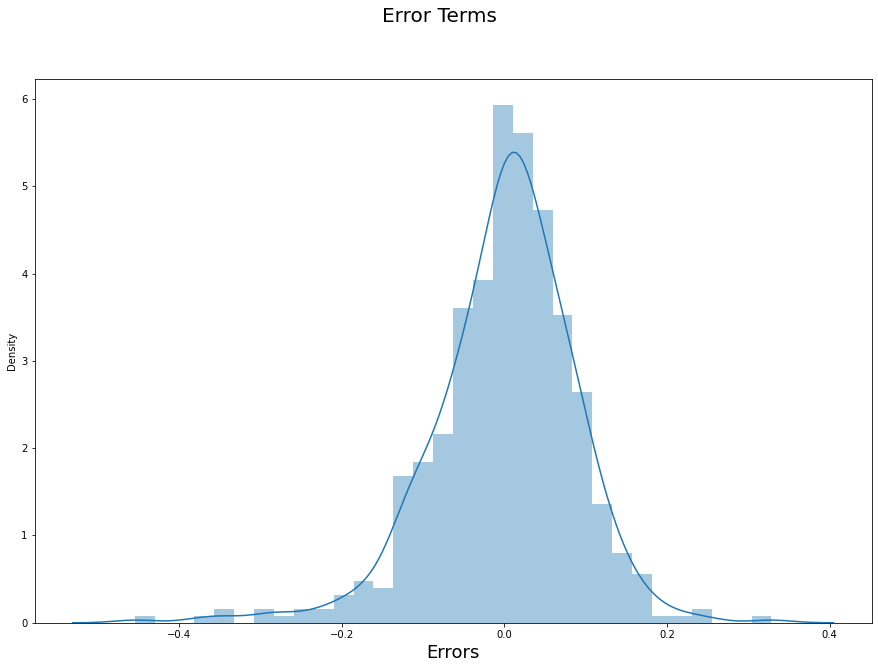

In [41]:
# Plotting the residuals to confirm the Linear Regression Assumptions
res = y_train - y_train_pred
fig = plt.figure()
sns.distplot(res)
fig.suptitle('Error Terms', fontsize = 20)  
plt.xlabel('Errors', fontsize = 18) 
plt.show()

#### Assumptions verified:
- Residuals seems to have zero mean and follow normal distribution 

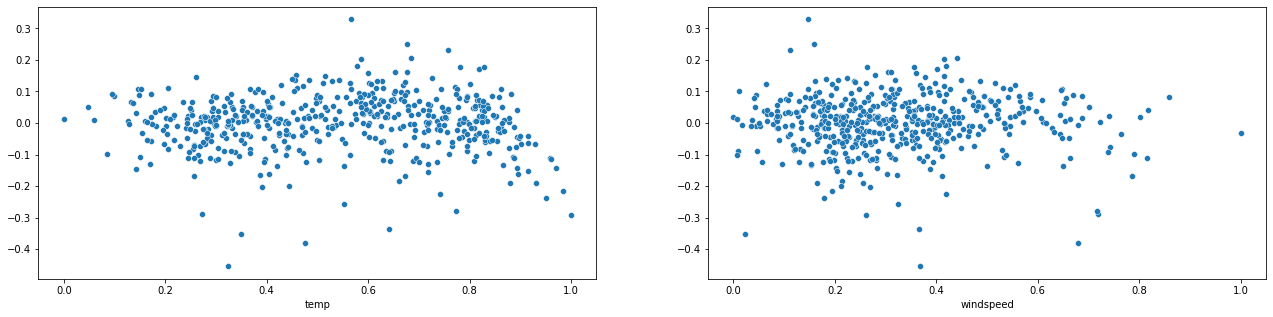

In [42]:
plt.figure(figsize=(22,5))
plt.subplot(1,2,1)
sns.scatterplot(x=X_train_rfe_m['temp'],y=res)
plt.subplot(1,2,2)
sns.scatterplot(x=X_train_rfe_m['windspeed'],y=res)
plt.show()

#### Assumptions verified:
- Residuals doesn't seem to have any pattern and independent
- Residuals seems to have constant variance most of the time except for some outliers

### Step 5:  Predictions and Evaluations using the Final Model

#### Applying the Scaling on test sets


In [43]:
# Normalize the numerical columns other than categorical dummy cols
num_vars = ['temp','atemp','hum','windspeed','cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,yr_2019,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light_Snow,weathersit_Mist_Cloudy
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.481818,0.254545,0.263636,...,0.086364,0.086364,0.145455,0.177273,0.118182,0.100000,0.127273,0.168182,0.027273,0.318182
std,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.500809,0.436599,0.441609,...,0.281541,0.281541,0.353363,0.382770,0.323559,0.300684,0.334038,0.374881,0.163248,0.466833
min,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Splitting the test set into X and y


In [44]:
y_test = df_test.pop('cnt')
X_test = df_test

In [45]:
# Removing columns which were removed during model building process
X_test_final = X_test[X_train_rfe_m.columns] 
X_test_final.columns

Index(['workingday', 'temp', 'windspeed', 'yr_2019', 'season_spring',
       'season_summer', 'season_winter', 'mnth_Dec', 'mnth_Jan', 'mnth_Jul',
       'mnth_Nov', 'mnth_Sep', 'weekday_Sun', 'weathersit_Light_Snow',
       'weathersit_Mist_Cloudy'],
      dtype='object')

In [46]:
y_test_pred = final_model.predict(add_constant(X_test_final))
y_test_pred

184    0.418754
535    0.891123
299    0.430858
221    0.582422
152    0.557954
         ...   
702    0.712038
127    0.477235
640    0.812785
72     0.293521
653    0.751901
Length: 220, dtype: float64

In [47]:
# Rsquare of model from the test set
r_square_test = r2_score(y_test,y_test_pred)
r_square_test

0.8168681962672554

#### Observations
- r_square of test set is just 3% less than that of training set. This implies model generalizes quite well

## Final Equation of the model
cnt = 0.1985 + 0.0547 * workingday + 0.4354 * temp  + 0.2348 * yr_2019 + 0.0354 * season_summer + 0.0903 * season_winter + 0.0652 * mnth_Sep + 0.0670 * weekday_Sun - 0.1609 * windspeed - 0.0713 * season_spring - 0.0467 * mnth_Dec - 0.0526 * mnth_Jan - 0.0466 * mnth_Jul - 0.0447 * mnth_Nov - 0.2969 * weathersit_Light_Snow - 0.0818 * weathersit_Mist_Cloudy